In [97]:
!pip install xgboost shap pandas scikit-learn matplotlib

In [98]:
import pandas as pd

df = pd.read_csv("/Users/emmali/PyCharmMiscProject/final_real.csv")
print(df.head())


              business_id  stars  checkin_count  BusinessAcceptsCreditCards  \
0  MTSW4McQd7CbVtyjqoe9mw    4.0            324                           0   
1  MUTTqe8uqyMdBl186RmNeA    4.0            172                           1   
2  ROeacJQwBeh05Rqg7F6TCg    4.5            221                           1   
3  QdN72BWoyFypdGJhhI5r7g    4.0             81                           1   
4  Mjboz24M9NlBeiOJKLEd_Q    3.0              9                           1   

   BusinessParking  RestaurantsTakeOut  RestaurantsPriceRange2  \
0                1                   1                       1   
1                1                   1                       2   
2                1                   1                       1   
3                1                   1                       2   
4                0                   1                       1   

   OutdoorSeating  BikeParking  RestaurantsReservations  ...  Latin American  \
0               0            1                  

In [99]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import smogn

df = pd.read_csv("/Users/emmali/PyCharmMiscProject/final_many_point_UTF-8.csv")

feature_columns = [
    "checkin_count", "BusinessAcceptsCreditCards", "WiFi","HasTV","BikeParking","OutdoorSeating", "RestaurantsPriceRange2","BusinessParking",
     "RestaurantsReservations",
    "Alcohol", "GoodForKids", "text_count", "avg_sentiment","RestaurantsTakeOut","taste_sentiment","service_sentiment","ambience_sentiment","local_cuisine_preference_score"
]

X = df[feature_columns]  # 特征数据
y = df["stars"]          # 目标变量



In [100]:
# 将数据分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [101]:
df_train = X_train.copy()
df_train["stars"] = y_train

df_train = df_train.fillna(df_train.median(numeric_only=True))

print(df_train.isnull().sum())

# 用中位数填充数值列，用众数填充非数值列
for col in df_train.columns:
    if df_train[col].isnull().sum() > 0:
        if df_train[col].dtype in ['float64', 'int64']:
            df_train[col] = df_train[col].fillna(df_train[col].median())
        else:
            df_train[col] = df_train[col].fillna(df_train[col].mode()[0])


df_smogn = smogn.smoter(
    data =df_train ,
    y = "stars",         # 目标变量的列名
    k = 5,               # KNN 用于插值的邻居数
    samp_method = "extreme"
)
X_smogn = df_smogn.drop(columns=["stars"])
y_smogn = df_smogn["stars"]



checkin_count                     0
BusinessAcceptsCreditCards        0
WiFi                              0
HasTV                             0
BikeParking                       0
OutdoorSeating                    0
RestaurantsPriceRange2            0
BusinessParking                   0
RestaurantsReservations           0
Alcohol                           0
GoodForKids                       0
text_count                        0
avg_sentiment                     0
RestaurantsTakeOut                0
taste_sentiment                   0
service_sentiment                 0
ambience_sentiment                0
local_cuisine_preference_score    0
stars                             0
dtype: int64


r_index: 100%|##########| 585/585 [00:00<00:00, 2048.17it/s]


In [102]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05, 0.01]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_score = -float("inf")   # 如果用MSE，写 float("inf")
best_score_mse = float("inf")
best_params = None

# 遍历参数组合
for n_est in param_grid["n_estimators"]:
    for depth in param_grid["max_depth"]:
        for lr in param_grid["learning_rate"]:
            acc_list = []
            mse_list = []

            # K折交叉验证
            for train_idx, val_idx in kf.split(X_train):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                model = XGBRegressor(
                    n_estimators=n_est,
                    max_depth=depth,
                    learning_rate=lr,
                    random_state=42
                )
                model.fit(X_tr, y_tr)
                preds = model.predict(X_val)

            mse = mean_squared_error(y_val, preds)
            mse_list.append(mse)

            # 误差≤0.5算正确
            acc = np.mean(np.abs(preds - y_val) <= 0.5)
            acc_list.append(acc)

            mean_mse = np.mean(mse_list)
            mean_acc = np.mean(acc_list)
            print(f"n_estimators={n_est}, max_depth={depth}, lr={lr}, mean ACC={mean_acc:.4f}")
            print(f"depth={depth}, lr={lr}, mean MSE={mean_mse:.4f}")

            if mean_acc > best_score:
                best_score = mean_acc
                best_params = (n_est, depth, lr)

            if mean_mse < best_score_mse:
                best_score_mse = mean_mse
                best_params_mse = (n_est, depth, lr)



print("besr set:", best_params, "the ACC:", best_score)
print("best set based on mse", best_params_mse,"the mse：", best_score_mse)


n_estimators=100, max_depth=3, lr=0.1, mean ACC=0.7805
depth=3, lr=0.1, mean MSE=0.2002
n_estimators=100, max_depth=3, lr=0.05, mean ACC=0.7688
depth=3, lr=0.05, mean MSE=0.2058
n_estimators=100, max_depth=3, lr=0.01, mean ACC=0.6403
depth=3, lr=0.01, mean MSE=0.3068
n_estimators=100, max_depth=5, lr=0.1, mean ACC=0.7896
depth=5, lr=0.1, mean MSE=0.2023
n_estimators=100, max_depth=5, lr=0.05, mean ACC=0.7883
depth=5, lr=0.05, mean MSE=0.1997
n_estimators=100, max_depth=5, lr=0.01, mean ACC=0.6649
depth=5, lr=0.01, mean MSE=0.2851
n_estimators=100, max_depth=7, lr=0.1, mean ACC=0.7831
depth=7, lr=0.1, mean MSE=0.2099
n_estimators=100, max_depth=7, lr=0.05, mean ACC=0.7909
depth=7, lr=0.05, mean MSE=0.2019
n_estimators=100, max_depth=7, lr=0.01, mean ACC=0.6844
depth=7, lr=0.01, mean MSE=0.2735
n_estimators=300, max_depth=3, lr=0.1, mean ACC=0.7844
depth=3, lr=0.1, mean MSE=0.1993
n_estimators=300, max_depth=3, lr=0.05, mean ACC=0.7844
depth=3, lr=0.05, mean MSE=0.2003
n_estimators=300, 

In [103]:
model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)

model.fit(X_smogn, y_smogn)

# 在训练后直接预测测试集
y_pred = model.predict(X_test)

def compute_accuracy(y_true, y_pred, tolerance=0.5):
    correct = np.abs(y_true - y_pred) <= tolerance
    accuracy = np.mean(correct)
    return accuracy

accuracy = compute_accuracy(y_test.values, y_pred)

print(f"Prediction Accuracy (±0.5 tolerance): {accuracy:.4f}")


Prediction Accuracy (±0.5 tolerance): 0.7334


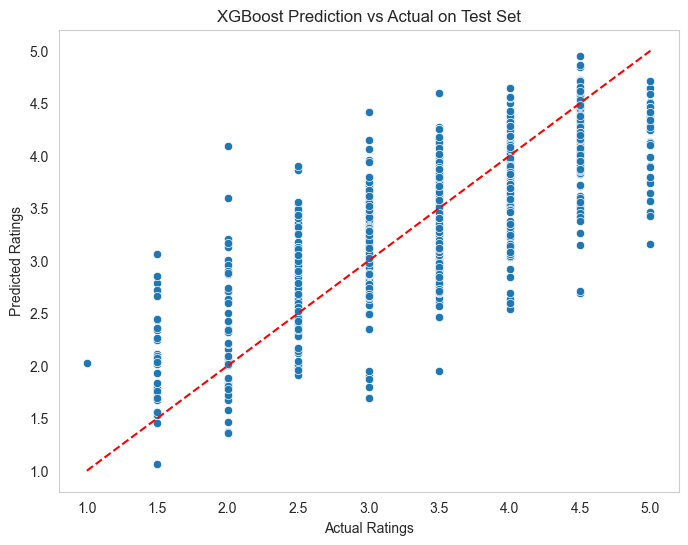

In [104]:
plt.figure(figsize=(8, 6))

sns.scatterplot(x=y_test, y=y_pred)
# _rounded
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("XGBoost Prediction vs Actual on Test Set")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 画对角线
plt.grid()
plt.show()


In [106]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_list = []
r2_list = []
acc_list = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    rmse_list.append(rmse)

    # R²
    r2_list.append(r2_score(y_val, preds))

    acc = np.mean(np.abs(preds - y_val) <= 0.5)
    acc_list.append(acc)

print("average RMSE：", np.mean(rmse_list))
print("average R²：", np.mean(r2_list))
print("average ACC:", np.mean(acc_list))


average RMSE： 0.4517325141148338
average R²： 0.667100140046861
average ACC: 0.7835630172935872


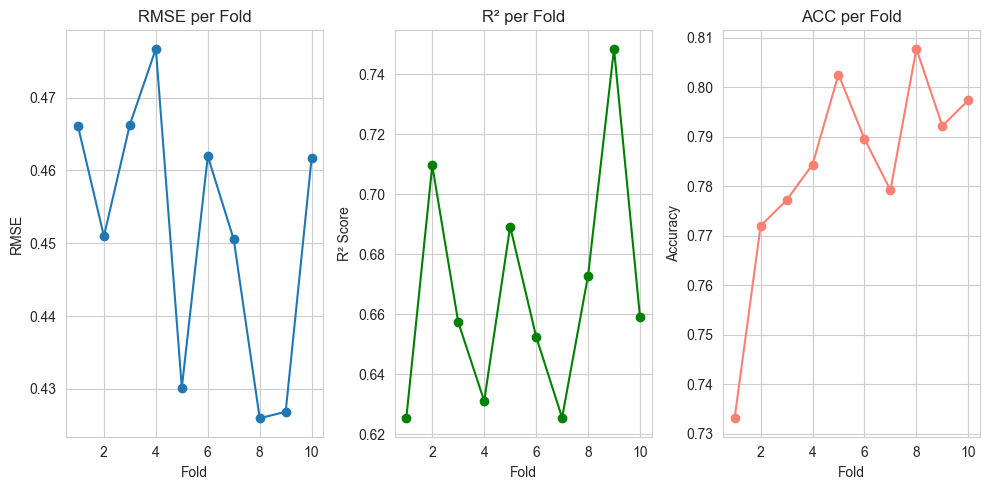

In [107]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 11), rmse_list, marker='o')
plt.title("RMSE per Fold")
plt.xlabel("Fold")
plt.ylabel("RMSE")

plt.subplot(1, 3, 2)
plt.plot(range(1, 11), r2_list, marker='o', color='green')
plt.title("R² per Fold")
plt.xlabel("Fold")
plt.ylabel("R² Score")

plt.subplot(1, 3, 3)
plt.plot(range(1, 11), acc_list, marker='o', color='salmon')
plt.title("ACC per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")


plt.tight_layout()
plt.show()


In [108]:
final_rmse =  np.sqrt(mean_squared_error(y_test, y_pred))

final_r2 = r2_score(y_test, y_pred)

final_acc = np.mean(np.abs(y_pred - y_test) <= 0.5)

print("Final Test Set RMSE:", final_rmse)
print("Final Test Set R²:", final_r2)
print("Final Test Set ACC:", final_acc)


Final Test Set RMSE: 0.49857031749124975
Final Test Set R²: 0.6495074251247568
Final Test Set ACC: 0.733402489626556


Average ACC (±0.5): 0.7836


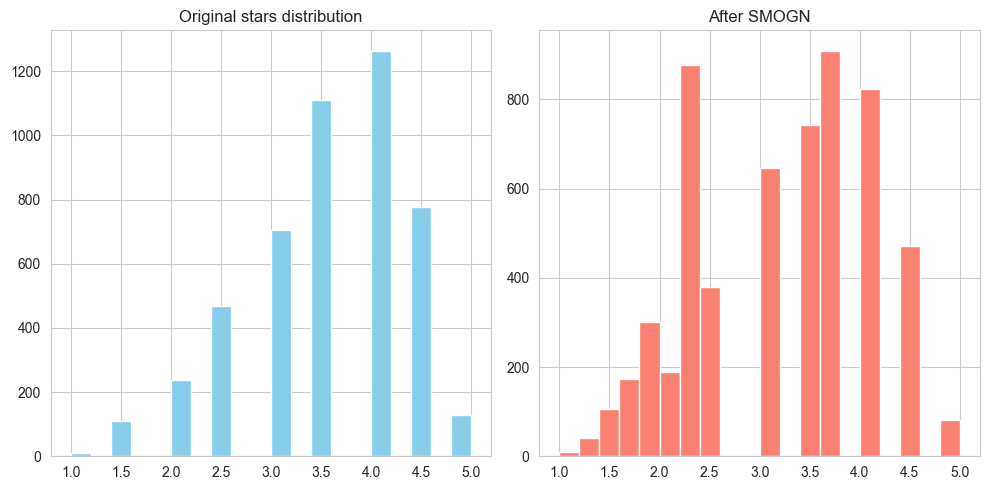

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(y, bins=20, color='skyblue')
plt.title("Original stars distribution")

plt.subplot(1, 2, 2)
plt.hist(y_smogn, bins=20, color='salmon')
plt.title("After SMOGN")

print(f"Average ACC (±0.5): {np.mean(acc_list):.4f}")

plt.tight_layout()
plt.show()
